# Introduction



Lending Club adalah perusahaan *peer to peer lending* yang berbasis di Amerika Serikat, di mana investor menyediakan dana untuk calon peminjam, dan mendapatkan keuntungan tergantung pada risiko yang mereka ambil (skor kredit peminjam). Lending Club menyediakan "jembatan" antara investor dan peminjam. 

Meskipun sempat berkembang pesat hingga mencatatkan diri di bursa, sejak 2020 Lending Club menghentikan layanan P2P lendingnya.

Untuk informasi lebih jauh, silakan lihat [artikel wikipedia ini](https://en.wikipedia.org/wiki/LendingClub). 

#Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

#package untuk preprosesing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

#from scipy.cluster import hierarchy

#estimator yang akan kita gunakan
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, OPTICS

#visualisasi elbow method dan silhouette score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

#metriks untuk evaluasi
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score


In [ ]:
#setting display pandas
pd.options.display.max_columns = 200
pd.options.display.max_rows = 1000

# Data Preprocessing


## Loading data



In [ ]:
filename = "https://raw.githubusercontent.com/aapatel09/handson-unsupervised-learning/master/datasets/lending_club_data/LoanStats3a.csv"
df_bank = pd.read_csv(filename, low_memory=False)

print('Dataframe shape:', df_bank.shape)
df_bank.head()

Dataframe shape: (42542, 145)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,NaN,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648.0,83.70%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62,NaN,Jun-18,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,NaN,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687.0,9.40%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66,NaN,Oct-16,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,NaN,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956.0,98.50%,10.0,f,0.0,0.0,3005.666844,3

Dari 145 kolom yang tersedia, kita akan mengambil beberapa kolom saja, seperti di bawah ini : 

In [ ]:
col2keep = ["loan_amnt","funded_amnt","funded_amnt_inv","loan_status", \
            "emp_length","installment", "int_rate","term","dti","annual_inc", "pub_rec", \
            "total_acc","grade"] 
data = df_bank.loc[:,col2keep]

Keterangan kolom :
* loan_amnt 	: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* funded_amnt : The total amount committed to that loan at that point in time
* funded_amnt_inv	: The total amount committed by investors for that loan at that point in time.
* term 		: The number of payments on the loan. Values are in months and can be either 36 or 60.
int_rate 	: Interest Rate on the loan
* installment 	: The monthly payment owed by the borrower if the loan originates.
* grade 		: LC assigned loan grade
* emp_length 	: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
* annual_inc 	: The self-reported annual income provided by the borrower during registration.
* loan_status 	: Current status of the loan
* dti 		: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* total_acc 	: The total number of credit lines currently in the borrower's credit file


##Eksplorasi Data Sekilas

In [ ]:
#tampilkan jumlah record dan kolom 
data.shape

(42542, 13)

Tampilkan 5 baris pertama

In [ ]:
data.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,loan_status,emp_length,installment,int_rate,term,dti,annual_inc,pub_rec,total_acc,grade
0,5000.0,5000.0,4975.0,Fully Paid,10+ years,162.87,10.65%,36 months,27.65,24000.0,0.0,9.0,B
1,2500.0,2500.0,2500.0,Charged Off,< 1 year,59.83,15.27%,60 months,1.00,30000.0,0.0,4.0,C
2,2400.0,2400.0,2400.0,Fully Paid,10+ years,84.33,15.96%,36 months,8.72,12252.0,0.0,10.0,C
3,10000.0,10000.0,10000.0,Fully Paid,10+ years,339.31,13.49%,36 months,20.00,49200.0,0.0,37.0,C
4,3000.0,3000.0,3000.0,Fully Paid,1 year,67.79,12.69%,60 months,17.94,80000.0,0.0,38.0,B


Kita lihat ada beberapa kolom yang masih berupa teks, seperti `loan_status`, `emp_length`, `term`, dan `grade`.

Kita akan melakukan pemrosesan data untuk kolom-kolom ini nanti.

Tampilkan nama dan tipe kolom

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42542 entries, 0 to 42541
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   loan_amnt        42535 non-null  float64
 1   funded_amnt      42535 non-null  float64
 2   funded_amnt_inv  42535 non-null  float64
 3   loan_status      42535 non-null  object 
 4   emp_length       41423 non-null  object 
 5   installment      42535 non-null  float64
 6   int_rate         42535 non-null  object 
 7   term             42535 non-null  object 
 8   dti              42535 non-null  float64
 9   annual_inc       42531 non-null  float64
 10  pub_rec          42506 non-null  float64
 11  total_acc        42506 non-null  float64
 12  grade            42535 non-null  object 
dtypes: float64(8), object(5)
memory usage: 4.2+ MB


Tampilkan statistik data

In [ ]:
data.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,dti,annual_inc,pub_rec,total_acc
count,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,4.253100e+04,42506.000000,42506.000000
mean,11089.722581,10821.585753,10139.938785,322.623063,13.373043,6.913656e+04,0.058156,22.124406
std,7410.938391,7146.914675,7131.598014,208.927216,6.726315,6.409635e+04,0.245713,11.592811
min,500.000000,500.000000,0.000000,15.670000,0.000000,1.896000e+03,0.000000,1.000000
25%,5200.000000,5000.000000,4950.000000,165.520000,8.200000,4.000000e+04,0.000000,13.000000
50%,9700.000000,9600.000000,8500.000000,277.690000,13.470000,5.900000e+04,0.000000,20.000000
75%,15000.000000,15000.000000,14000.000000,428.180000,18.680000,8.250000e+04,0.000000,29.000000
max,35000.000000,35000.000000,35000.000000,1305.190000,29.990000,6.000000e+06,5.000000,90.000000


##Data Cleansing

###Null value

In [ ]:
data.isnull().sum()

loan_amnt             7
funded_amnt           7
funded_amnt_inv       7
loan_status           7
emp_length         1119
installment           7
int_rate              7
term                  7
dti                   7
annual_inc           11
pub_rec              36
total_acc            36
grade                 7
dtype: int64

In [ ]:
data[data['loan_amnt'].isnull()]

,loan_amnt,funded_amnt,funded_amnt_inv,loan_status,emp_length,installment,int_rate,term,dti,annual_inc,pub_rec,total_acc,grade
39786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Karena record di atas semua kolomnya bernilai Null, kita remove saja records tersebut.

In [ ]:
data = data.dropna(subset=['loan_amnt'])

In [ ]:
data.isna().sum()

loan_amnt             0
funded_amnt           0
funded_amnt_inv       0
loan_status           0
emp_length         1112
installment           0
int_rate              0
term                  0
dti                   0
annual_inc            4
pub_rec              29
total_acc            29
grade                 0
dtype: int64

###Cek variabel kategorik

Tampilkan nilai unik untuk variabel kategorik, untuk melihat apakah kita perlu melakukan cleansing.

In [ ]:
cat_cols = ['loan_status', 'grade']

for i in cat_cols:
  print(i, " :\n", data[i].unique())

loan_status  :
 ['Fully Paid' 'Charged Off'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']
grade  :
 ['B' 'C' 'A' 'E' 'F' 'D' 'G']


Kita akan sederhanakan nilai kolom `loan_status` dari 4 menjadi 2 saja.

In [ ]:
data = data.replace({'loan_status' : { 'Does not meet the credit policy. Status:Fully Paid' : 'Fully Paid', \
                             'Does not meet the credit policy. Status:Charged Off' : 'Charged Off'}})

In [ ]:
data['loan_status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

###Reformat variabel numerik

Ambil nilai numerik dari kolom  `loan_status`, `emp_length`, dan `term`. Kita akan gunakan `re` (regex).

Lebih lanjut tentang regular expression dalam python dapat dibaca [di sini](https://docs.python.org/3/howto/regex.html)

In [ ]:
for i in ["term","int_rate","emp_length"]:
    data.loc[:,i] = \
        data.loc[:,i].apply(lambda x: re.sub("[^0-9]", "", str(x)))
    data.loc[:,i] = pd.to_numeric(data.loc[:,i])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42535 entries, 0 to 42537
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   loan_amnt        42535 non-null  float64
 1   funded_amnt      42535 non-null  float64
 2   funded_amnt_inv  42535 non-null  float64
 3   loan_status      42535 non-null  object 
 4   emp_length       41423 non-null  float64
 5   installment      42535 non-null  float64
 6   int_rate         42535 non-null  int64  
 7   term             42535 non-null  int64  
 8   dti              42535 non-null  float64
 9   annual_inc       42531 non-null  float64
 10  pub_rec          42506 non-null  float64
 11  total_acc        42506 non-null  float64
 12  grade            42535 non-null  object 
dtypes: float64(9), int64(2), object(2)
memory usage: 4.5+ MB


###Imputasi Null 

Cek kolom apa saja yang memiliki nilai Null.

In [ ]:
data.isna().sum()

loan_amnt             0
funded_amnt           0
funded_amnt_inv       0
loan_status           0
emp_length         1112
installment           0
int_rate              0
term                  0
dti                   0
annual_inc            4
pub_rec              29
total_acc            29
grade                 0
dtype: int64

Kita akan melakukan 3 macam imputasi, yaitu imputasi dengan nilai rata-rata, dengan nilai 0, dan nilai 1.

In [ ]:
im = SimpleImputer(strategy='mean')   
data.loc[:,['emp_length','annual_inc']] = im.fit_transform(data[['emp_length','annual_inc']])

data.loc[:,['pub_rec','dti']] = data.loc[:,['pub_rec','dti']].fillna(value=0,axis=1)
data.loc[:,['total_acc']] = data.loc[:,['total_acc']].fillna(value=1,axis=1)

##Eksplorasi Data

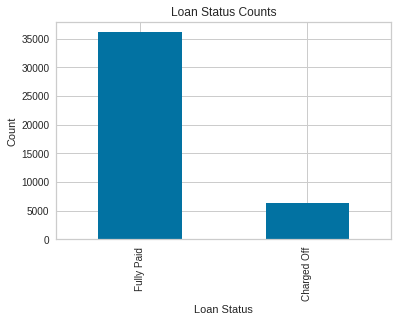

In [ ]:
data['loan_status'].value_counts().plot.bar(
    title="Loan Status Counts", xlabel='Loan Status', ylabel='Count'
)

Cek outlier

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


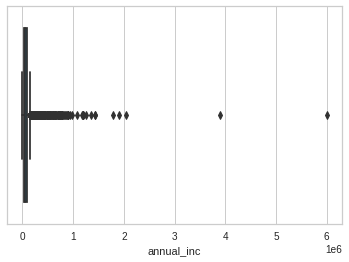

In [ ]:
sns.boxplot(data['annual_inc'])

In [ ]:
data[data['annual_inc']>200000].shape

(685, 13)

In [ ]:
data_=data[data['annual_inc']<200000]

##Transform ordinal features

Variabel non-numerik dari dataset kita termasuk variabel ordinal. 

Untuk variabel ordinal, kita akan mensubstitusi dengan nilai integer. Untuk variabel `grade` dari A sampai G, kita substitusi dengan integer 6 sampai 0, sedangkan `loan_status` kita substitusi dengan nilai 1 dan 0.

In [ ]:
data_enc = data_.replace({'loan_status' : { 'Fully Paid' : 1, 'Charged Off' : 0}, \
                     'grade' : {'A':6, 'B':5, 'C':4, 'D':3, 'E':2, 'F':1, 'G':0}
                     })

In [ ]:
data_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41717 entries, 0 to 42537
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   loan_amnt        41717 non-null  float64
 1   funded_amnt      41717 non-null  float64
 2   funded_amnt_inv  41717 non-null  float64
 3   loan_status      41717 non-null  int64  
 4   emp_length       41717 non-null  float64
 5   installment      41717 non-null  float64
 6   int_rate         41717 non-null  int64  
 7   term             41717 non-null  int64  
 8   dti              41717 non-null  float64
 9   annual_inc       41717 non-null  float64
 10  pub_rec          41717 non-null  float64
 11  total_acc        41717 non-null  float64
 12  grade            41717 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 4.5 MB


##Penskalaan variabel numerik



Karena kita akan melakukan clustering yang memanfaatkan jarak antar titik, kita akan lakukan penskalaan variabel terlebih dahulu agar  perbedaan skala tidak menyebabkan variabel-variabel tertentu mendominasi proses learning.

In [ ]:
#norm = StandardScaler().fit(data_enc)
norm = MinMaxScaler().fit(data_enc)
data_norm = norm.transform(data_enc)

#K-Means Clustering

Kita gunakan package `yellowbrick` untuk menampilkan Elbow score, untuk mencari jumlah cluster terbaik.

Kita cari k di rentang 2-10.

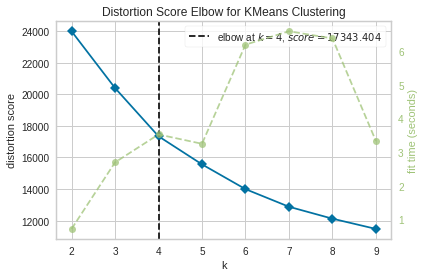

In [ ]:
model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, k=(2,10))

distortion_visualizer.fit(data_norm)       
distortion_visualizer.show()    

Selanjutnya kita jalankan `predict` untuk mendapatkan clusternya.

In [ ]:
km_model = KMeans(distortion_visualizer.elbow_value_, random_state=42)
labels = km_model.fit_predict(data_norm)#data_pca)

##Visualisasi & Evaluasi

In [ ]:
df_norm = pd.DataFrame(data= data_norm, columns=data_enc.columns)
df_norm['LABELS'] = labels

###Komposisi

Tampilkan komposisi.

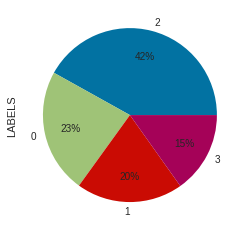

In [ ]:
ax = df_norm.LABELS.value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

###Clustering Score 

- **Indeks Davis-Bouldin** adalah kesamaan rata-rata antara tiap cluster dengan cluster terdekatnya. Kesamaan didefinisikan sebagai rasio jarak dalam cluster dengan jarak antar cluster. Skor bernilai >= 0. Semakin kecil nilai menunjukkan pengelompokan yang lebih baik.
- **Koefisien Silhouette** bernilai antara -1 sampai 1. Semakin tinggi semakin baik. Nilai 1 menunjukkan cluster yang ketat, dan 0 menunjukkan cluster yang overlap.

In [ ]:
print(f'Davies-Bouldin index = {davies_bouldin_score(df_norm, labels)}')
print(f'Silhouette Score = {silhouette_score(df_norm, labels)}')

Davies-Bouldin index = 0.857860429756589
Silhouette Score = 0.5168162680475716


Kita mendapatkan nilai sedang untuk silhouette score, yang mengindikasikan masih terdapat overlap pada cluster kita.

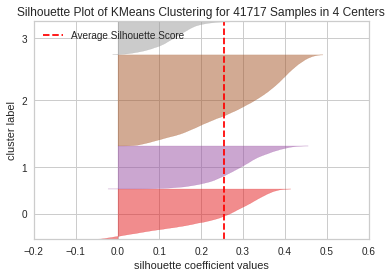

In [ ]:
visualizer = SilhouetteVisualizer(km_model)
visualizer.fit(data_norm)#data_pca.drop(['LABELS'],axis=1))
visualizer.show()

###Parallel Coordinates Plot

Untuk melihat hubungan tiap dimensi dengan clusternya, kita bisa menggunakan *parallel coordinates plot*.

Untuk menyederhanakan tampilan, kita akan mengambil nilai rata2 (mean) dari tiap kolom dan cluster.

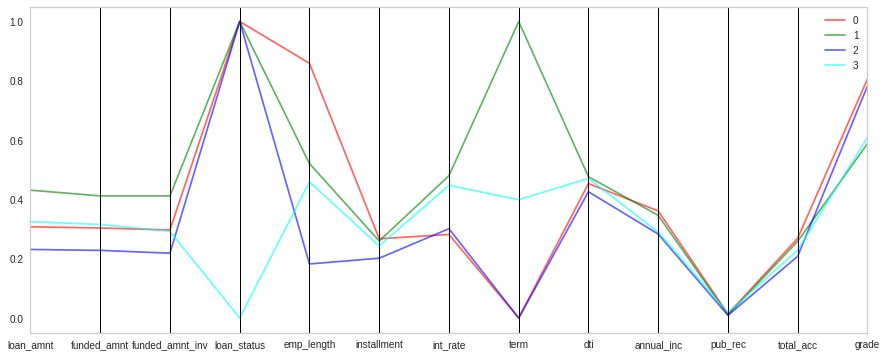

In [ ]:
means = df_norm.groupby("LABELS").mean().reset_index()
plt.figure(figsize = (15,6))
pd.plotting.parallel_coordinates(means, 'LABELS', color=['red','green','blue','cyan','orange'], alpha=.6)

###Interpretasi Cluster : Histogram by cluster

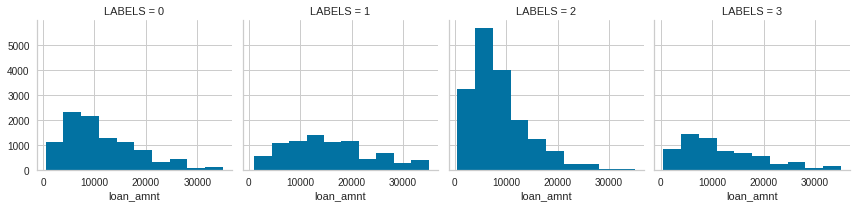

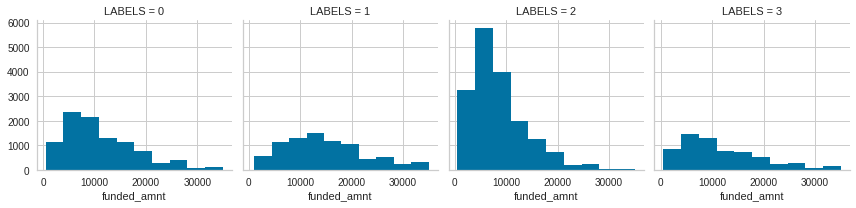

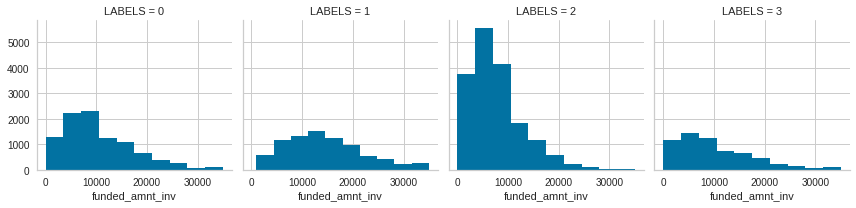

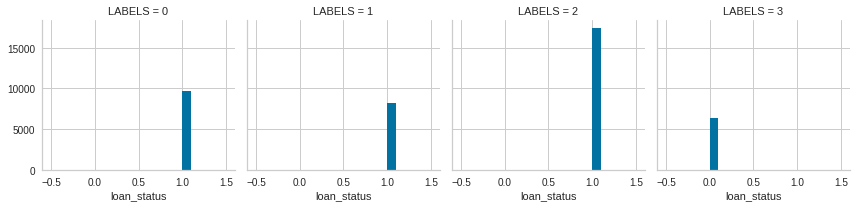

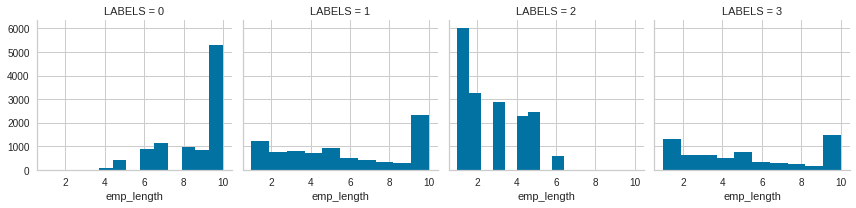

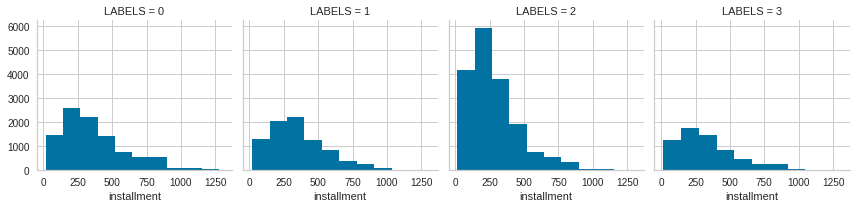

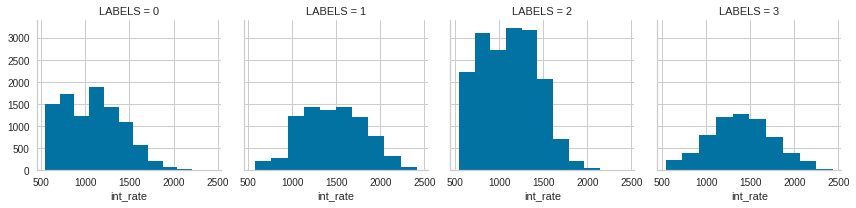

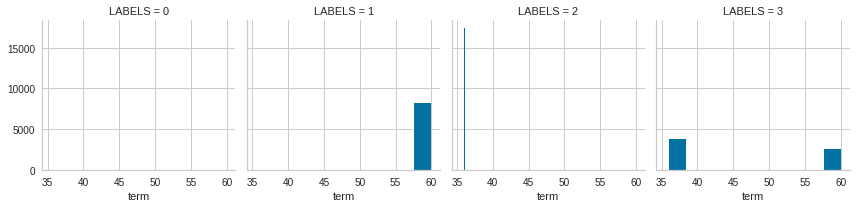

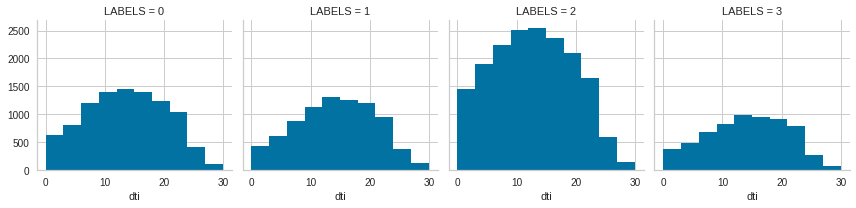

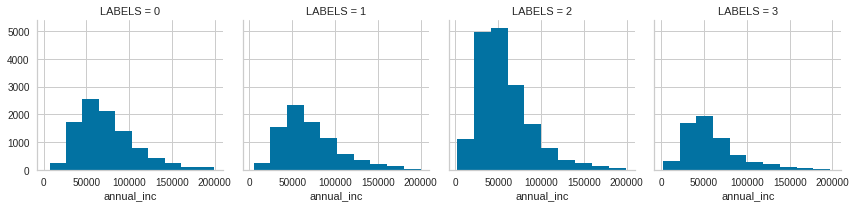

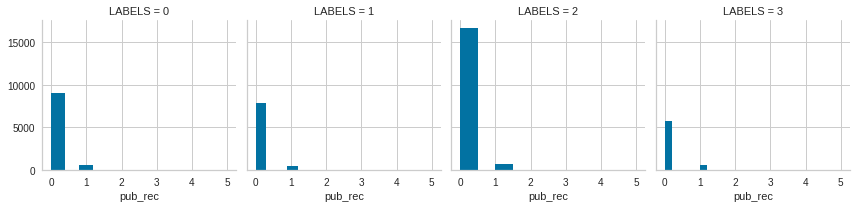

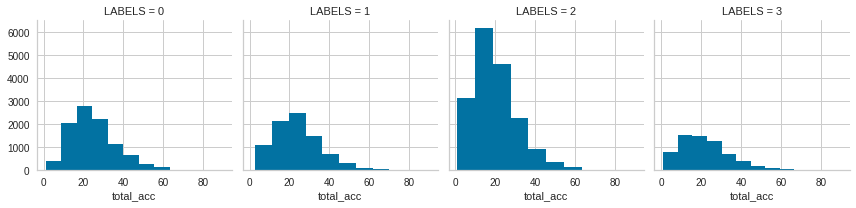

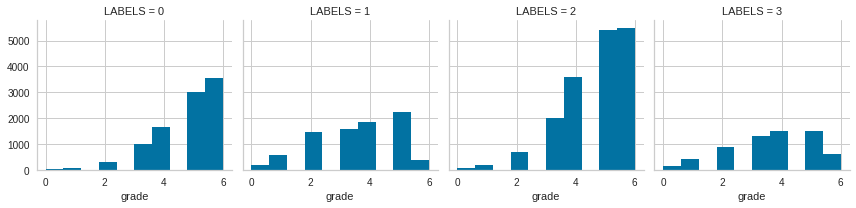

In [ ]:
data_enc['LABELS'] = labels
for c in data:
    grid= sns.FacetGrid(data_enc, col='LABELS')
    grid.map(plt.hist, c)

##PCA untuk Visualisasi Cluster : Density 2 Dimensi

Untuk menampilkan density plot 2 dimensi, kita akan lakukan PCA terlebih dahulu.

Sebelumnya kita akan menggunakan `StandardScaler` untuk standarisasi data. Kita akan menggunakan `pipeline` untuk merangkai 2 estimator sekaligus : `StandardScaler` dan `PCA`

In [ ]:
from sklearn.pipeline import make_pipeline

pipelinePCA = make_pipeline(StandardScaler(), PCA())
data_pca1 = pd.DataFrame(pipelinePCA.fit_transform(data_enc))

data_pca1.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,4.171700e+04,4.171700e+04,4.171700e+04,4.171700e+04,4.171700e+04,4.171700e+04,4.171700e+04,4.171700e+04,4.171700e+04,4.171700e+04,4.171700e+04,4.171700e+04,4.171700e+04,4.171700e+04
mean,8.001632e-16,-3.585171e-16,8.884552e-17,-1.080443e-16,2.368575e-19,-3.533515e-16,-1.050232e-15,-6.889626e-17,-2.901159e-16,6.749973e-17,-2.508614e-16,-5.738206e-17,-1.789538e-17,4.289816e-17
std,2.141860e+00,1.520210e+00,1.231801e+00,1.097507e+00,1.018933e+00,9.633638e-01,9.464073e-01,8.548199e-01,6.721320e-01,4.012997e-01,2.979158e-01,2.220594e-01,1.695579e-01,8.696203e-02
min,-4.104813e+00,-4.476902e+00,-5.319443e+00,-3.719801e+00,-2.249309e+00,-3.022729e+00,-3.167063e+00,-3.113124e+00,-3.205507e+00,-8.548071e-01,-5.458058e-01,-1.802718e+00,-5.456215e-01,-7.853480e-01
25%,-1.615901e+00,-1.036574e+00,-9.024666e-01,-7.733117e-01,-6.840584e-01,-5.923986e-01,-6.294876e-01,-5.712048e-01,-4.278561e-01,-3.170469e-01,-1.611842e-01,-1.379741e-01,-6.475614e-02,-3.673620e-02
50%,-4.608796e-01,-7.609179e-02,-5.498093e-02,-7.087200e-02,-1.248916e-01,-5.905182e-02,-3.655257e-02,-5.952016e-02,-1.007745e-02,-1.464516e-02,-5.706977e-02,2.312518e-03,-1.028371e-02,-5.087942e-03
75%,1.178957e+00,9.843334e-01,8.439002e-01,6.966663e-01,4.732155e-01,4.782293e-01,5.772023e-01,5.243051e-01,4.122724e-01,2.478816e-01,6.642875e-02,1.235291e-01,4.281641e-02,2.778505e-02
max,8.621227e+00,5.901315e+00,5.528564e+00,4.988312e+00,1.371902e+01,1.307061e+01,5.031019e+00,4.805434e+00,3.780390e+00,1.016329e+00,3.115646e+00,2.190047e+00,2.273791e+00,8.270552e-01


Bentuk list per cluster

In [ ]:
clusters_ = []
data_pca1['LABELS'] = labels

for i in range(km_model.n_clusters):
  clusters_.append(data_pca1[data_pca1['LABELS'] == i])

Tampilkan 2 primary component yang pertama, plot dengan density plot (`sns.kdeplot`)

Text(0, 0.5, '0')

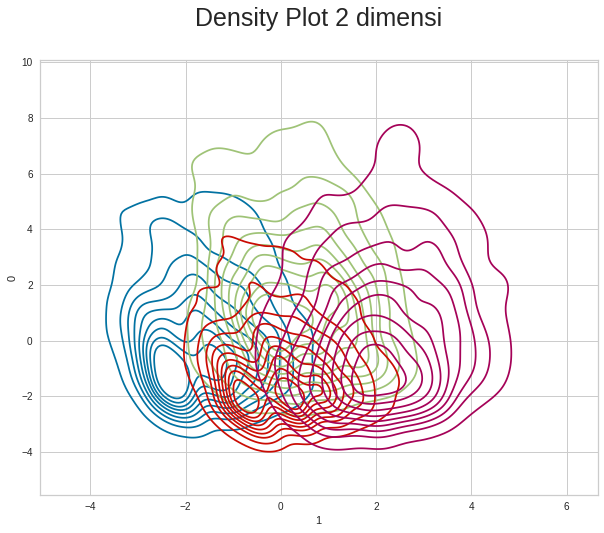

In [ ]:
plt.figure(figsize = (10,8))
plt.title("Density Plot 2 dimensi\n", size = 25)
ycol=0
xcol=1

for i in range(km_model.n_clusters):
  sns.kdeplot(x=clusters_[i][xcol], y=clusters_[i][ycol])
  #plt.scatter(clusters_[i][xcol], clusters_[i][ycol], s=50, label = "Cluster " + str(i), alpha = 0.3) 
  
plt.xlabel(xcol)
plt.ylabel(ycol)

###Joint Plot

Kita juga bisa menggunakan joint plot untuk menampilkan hasil clustering.

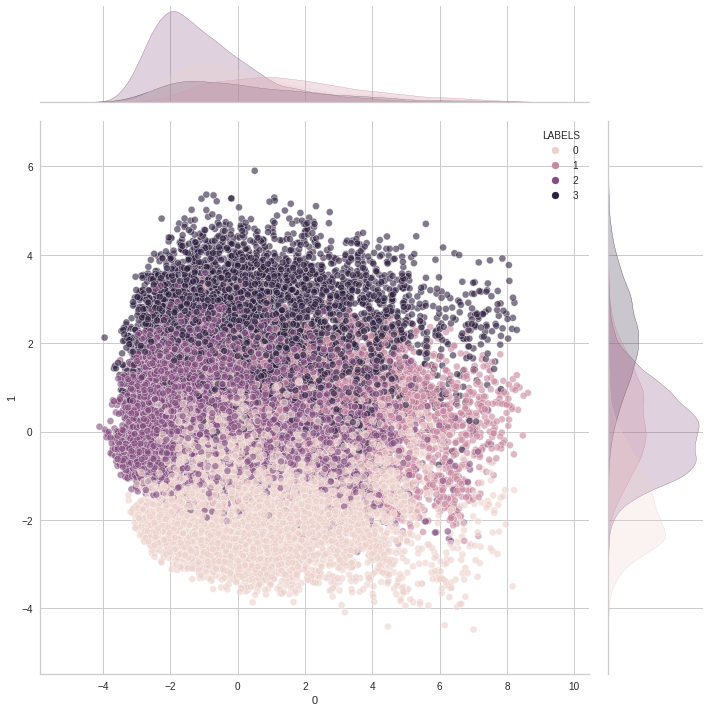

In [ ]:
sns.jointplot(data=data_pca1, x=0, y=1, hue="LABELS", alpha=0.6, height=10)

Jointplot juga bisa digunakan untuk menampilkan plot antara 2 variabel seperti contoh di bawah ini 

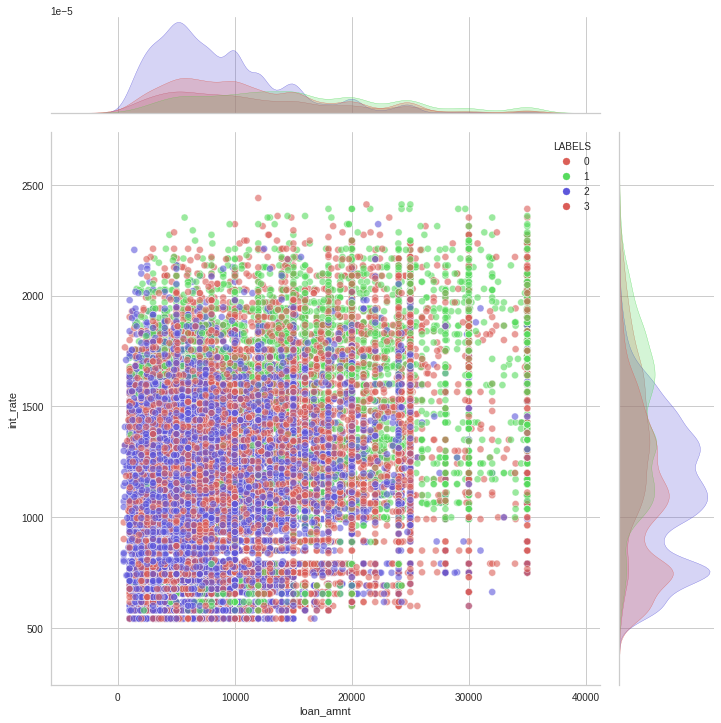

In [ ]:
sns.jointplot(data=data_enc, x='loan_amnt', y='int_rate', hue="LABELS", alpha=0.6, height=10, palette='hls')

#OPTICS Clustering

Kita akan menggunakan algoritma density-based clustering, yaitu OPTICS  (*Ordering Points To Identify the Clustering Structure*). 

In [ ]:
# optics clustering
opt=OPTICS(max_eps=30, min_samples=100)
opt_model=opt.fit(data_norm)
opt_clusters = opt_model.labels_

##Visualisasi dan Evaluasi

###Clustering Score

In [ ]:
print(f'Davies-Bouldin index = {davies_bouldin_score(data_norm, opt_clusters)}')
print(f'Silhouette Score = {silhouette_score(data_norm, opt_clusters)}')

Davies-Bouldin index = 1.2972240933687655
Silhouette Score = 0.34414840371862077


In [ ]:
df_norm['LABELS'] = opt_clusters

###Komposisi

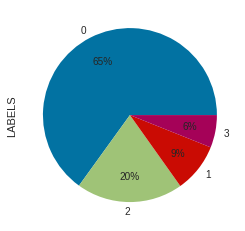

In [ ]:
df_norm.LABELS.value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

###Parallel Coordinates Plot

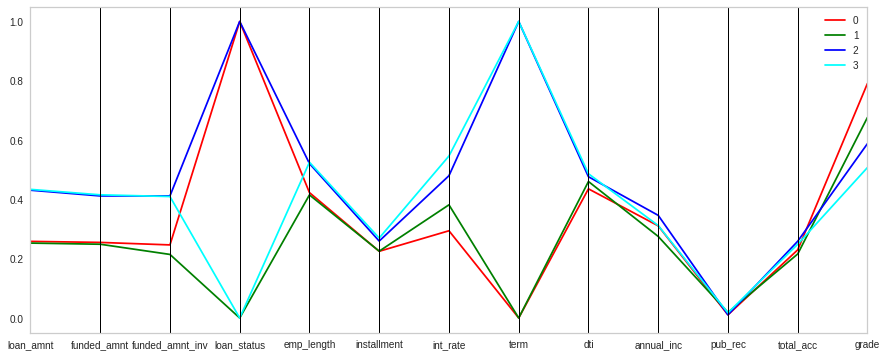

In [ ]:
df_norm['LABELS'] = opt_clusters
means = df_norm.groupby("LABELS").mean().reset_index()

plt.figure(figsize = (15,6))
pd.plotting.parallel_coordinates(means, 'LABELS', color=['red','green','blue','cyan','orange'])#, alpha=.5)


###Histogram by Cluster

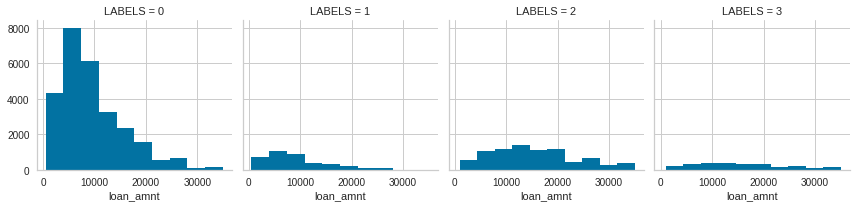

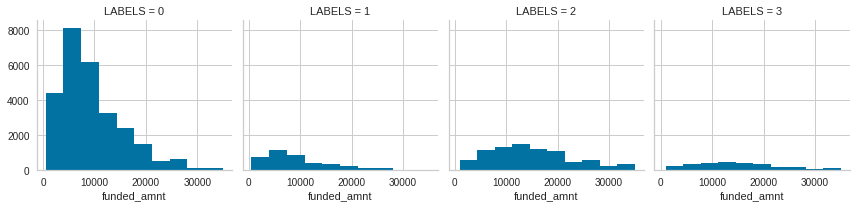

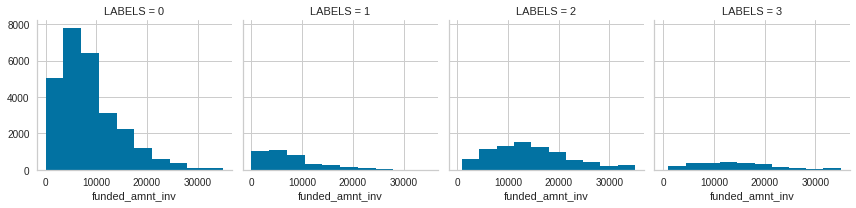

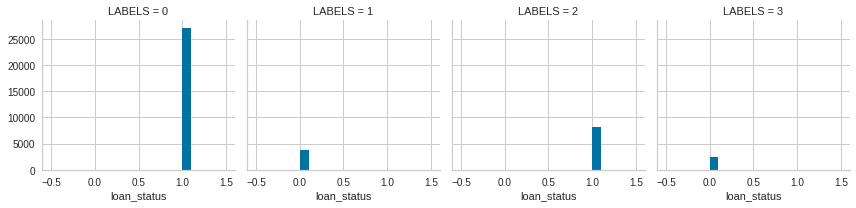

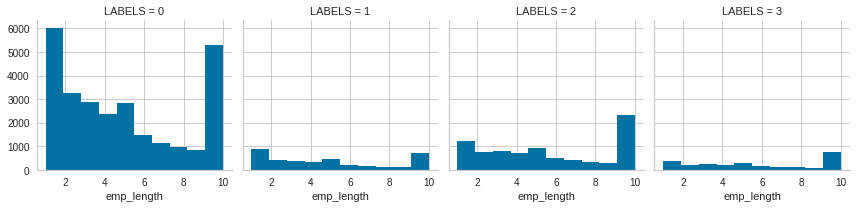

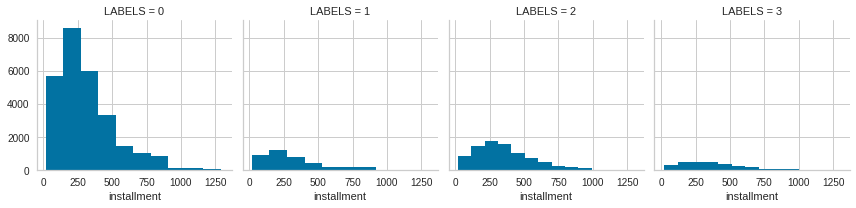

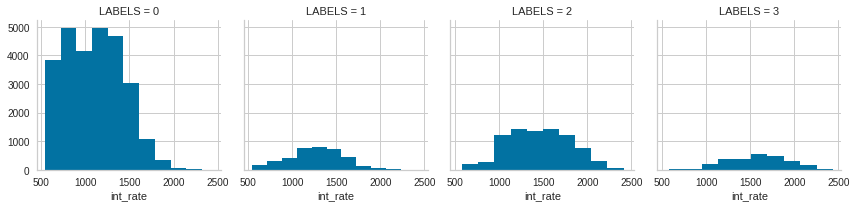

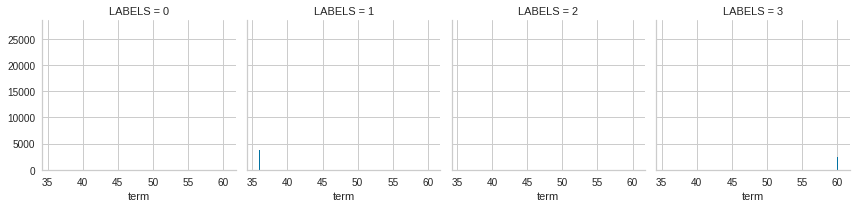

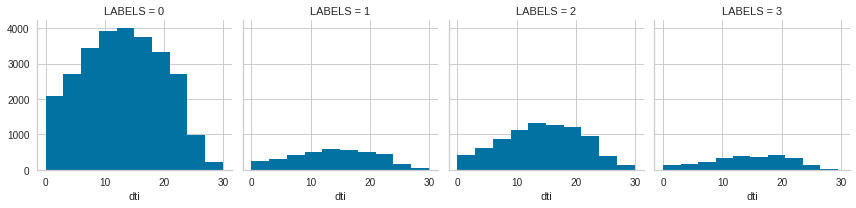

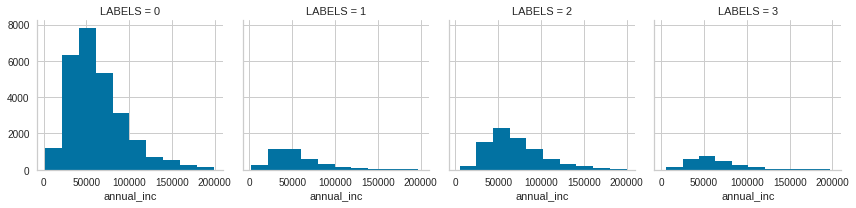

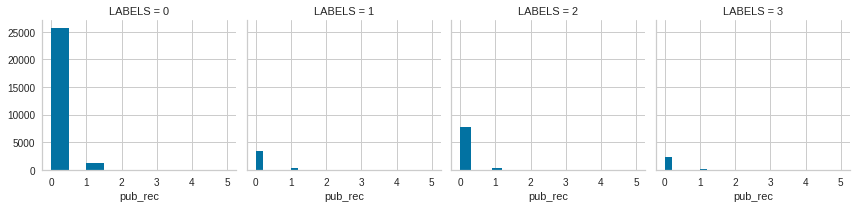

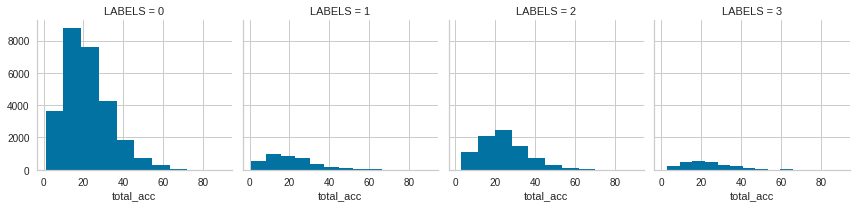

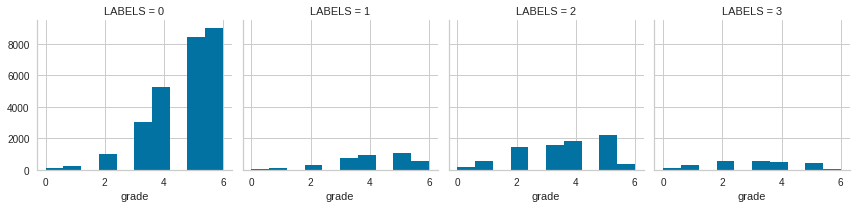

In [ ]:
data_enc['LABELS'] = opt_clusters
for c in data:
    grid= sns.FacetGrid(data_enc, col='LABELS')
    grid.map(plt.hist, c)

###Density plot 2D

In [ ]:
clusters_ = []
data_pca1['LABELS'] = opt_clusters

for i in np.unique(opt_clusters):
  clusters_.append(data_pca1[data_pca1['LABELS'] == i])

Text(0, 0.5, '0')

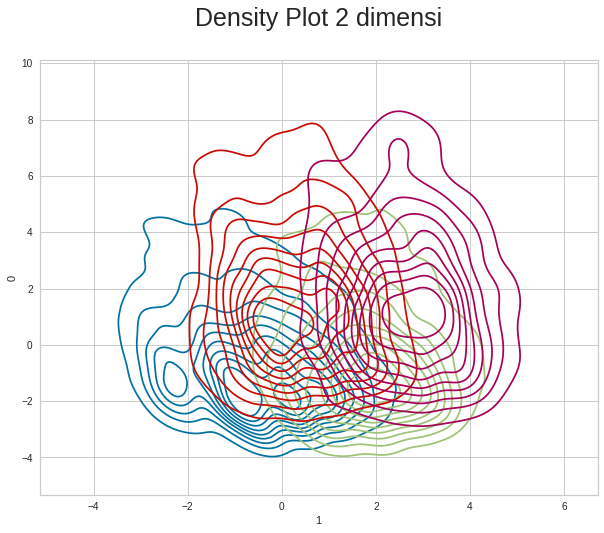

In [ ]:
plt.figure(figsize = (10,8))
plt.title("Density Plot 2 dimensi\n", size = 25)
ycol=0
xcol=1

for i in range(len(clusters_)):
  sns.kdeplot(x=clusters_[i][xcol], y=clusters_[i][ycol])
  #plt.scatter(clusters_[i][xcol], clusters_[i][ycol], s=50, label = "Cluster " + str(i), alpha = 0.3) 
  
plt.xlabel(xcol)
plt.ylabel(ycol)

##Joint Plot

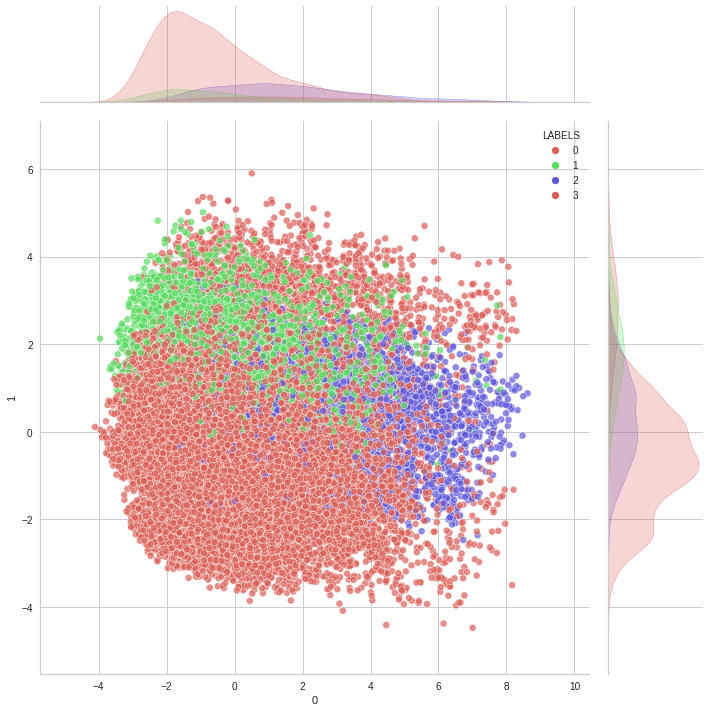

In [ ]:
data_pca1['LABELS']=opt_clusters
sns.jointplot(data=data_pca1, x=0, y=1, hue="LABELS", alpha=0.7, height=10, palette='hls')


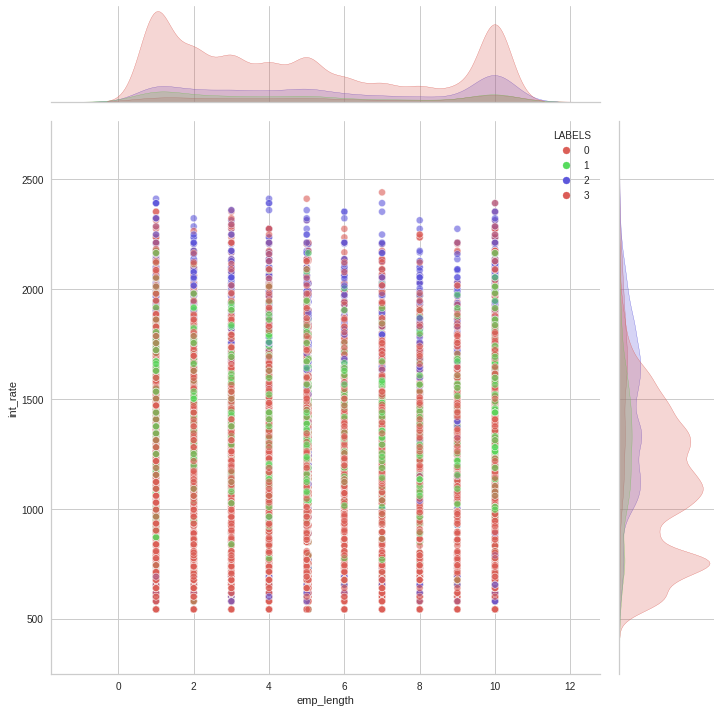

In [ ]:
sns.jointplot(data=data_enc, x='emp_length', y='int_rate', hue="LABELS", alpha=0.6, height=10, palette='hls')